# Imports

In [12]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from skimage import measure
import imageio
import cv2
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K

from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense, Flatten, Conv1D, Conv2D, Input, Conv2DTranspose, Concatenate, MaxPool1D, Dropout, Reshape, Lambda, InputLayer, LeakyReLU, BatchNormalization, GaussianNoise
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.losses import MeanSquaredError, kullback_leibler_divergence
from tensorflow.keras.metrics import BinaryCrossentropy

import warnings
import logging
warnings.simplefilter("ignore")
logging.getLogger("tensorflow").setLevel(logging.ERROR)

tf.autograph.set_verbosity(0)
os.environ['AUTOGRAPH_VERBOSITY'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

## Test GPU

In [2]:
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("GPUs available:",len(physical_devices))

GPUs available: 1


# Data preparation

Good = 25.40 %


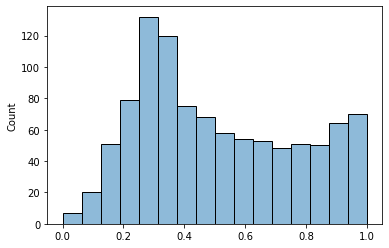

In [3]:
dimension = 2
simulation = '-m'
simulation = {'-m':'MATLAB','-r':'RTGA'}[simulation]
simmetry = 'p4'
score = 'isotropy'

if os.getcwd().split('\\')[2] == 'lucas':
    score_filename = 'E:/Lucas GAN/Dados/4- Mechanical_scores/%s/%sD/%s/%s.csv' %(simulation,dimension,simmetry,score)
    geom_epoch_dirs = 'E:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s/' %(dimension,simmetry,score)
    gif_filename = 'E:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s.gif' %(dimension,simmetry,score)
    tmp_models_dir = 'C:/Users/lucas/OneDrive/Documentos/GitHub/INT/Manufatura Aditiva/Simulacao-GAN/Pipeline/3- Machine_learning/GAN/tmp_models/'
    models_dir = 'E:/Lucas GAN/Dados/5- GAN_models/%sD/%s/%s/'%(dimension,simmetry,score)
    arrays_dir = 'E:/Lucas GAN/Dados/1- Arranged_geometries/GAN/%s/%s/' % (simmetry,score)
else:
    score_filename = 'D:/Lucas GAN/Dados/4- Mechanical_scores/%s/%sD/%s/%s.csv' %(simulation,dimension,simmetry,score)
    geom_epoch_dirs = 'D:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s/' %(dimension,simmetry,score)
    gif_filename = 'D:/Lucas GAN/Dados/7- Perfomance_data/%sD/geom_epoch/%s/%s.gif' %(dimension,simmetry,score)
    tmp_models_dir = 'C:/Users/lucas/OneDrive/Documentos/GitHub/INT/Manufatura Aditiva/Simulacao-GAN/Pipeline/3- Machine_learning/GAN/tmp_models/'
    models_dir = 'D:/Lucas GAN/Dados/5- GAN_models/%sD/%s/%s/'%(dimension,simmetry,score)
    arrays_dir = 'D:/Lucas GAN/Dados/1- Arranged_geometries/GAN/%s/%s/' % (simmetry,score)

data = np.loadtxt(score_filename,delimiter=',')
X = data[:,1:-1]
size = int(np.sqrt(X.shape[1]))
X = X.reshape((X.shape[0],size,size,1))

y = data[:,-1]
y = y.reshape((y.shape[0],1))

scaler = MinMaxScaler() 
y = scaler.fit_transform(y).round(10)

# cutoff = 0.56 # p4m
cutoff = 0.73 # p4

sns.histplot(y,legend=False,bins=16)
idxs_good = np.where(y>cutoff)[0]
idxs_bad = np.where(y<=cutoff)[0]

y = np.zeros(y.shape)
y[idxs_good] = 1.0
print(f"Good = %.2f %%"%(100*len(idxs_good)/(len(idxs_good)+len(idxs_bad))))
X_good = X[idxs_good]

input_G = 128
output_G = input_D = X.shape[1:]
output_D = 1

# Models definition

## Generator

In [4]:
def setup_G(input_G,output_G,size):
    size = int(size/2)
    in_G = Input(shape=(input_G,))

    # foundation for 8x8 image
    n_nodes = 128 * size * size
    out_G = Dense(n_nodes,activation=LeakyReLU(alpha=0.2))(in_G)
    # out_G = BatchNormalization()(out_G)
    out_G = LeakyReLU(alpha=0.2)(out_G)
    out_G = Reshape((size, size, 128))(out_G)
    # upsample to 16x16
    out_G = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same',activation=LeakyReLU(alpha=0.2))(out_G)
    # out_G = BatchNormalization()(out_G)
    out_G = LeakyReLU(alpha=0.2)(out_G)
    out_G = Conv2D(1, (size,size), activation='sigmoid', padding='same')(out_G)
    out_porosity = Lambda(lambda x:x)(out_G)
    out_validity = Lambda(lambda x:x)(out_G)

    model = Model(name='Generator',inputs=in_G,outputs=[out_G,out_porosity,out_validity])
    return model
setup_G(input_G,output_G,size).summary()

Model: "Generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 dense (Dense)                  (None, 8192)         1056768     ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu_1 (LeakyReLU)      (None, 8192)         0           ['dense[0][0]']                  
                                                                                                  
 reshape (Reshape)              (None, 8, 8, 128)    0           ['leaky_re_lu_1[0][0]']          
                                                                                          

## Discriminator

In [5]:
def wasserstein_loss(y_true, y_pred):
	return K.mean(y_true * y_pred)

def porosity_loss():
    def custom_loss(y_true,y_pred):
        size = y_pred.shape[1]*y_pred.shape[2]
        y_pred = K.round(y_pred)
        por_true = K.sum(K.sum(K.sum(y_true,axis=1),axis=1),axis=1)/size
        por_pred = K.sum(K.sum(K.sum(y_pred,axis=1),axis=1),axis=1)/size
        mse = tf.cast((por_true-por_pred)**2,tf.float32)
        return mse
    return custom_loss

def validity_loss():
    def custom_loss(y_true, y_pred):
        # @tf.function
        def connectivity_losss(element):
            size = element.shape[0]
            element = element.numpy().reshape((size,size))
            labels = measure.label(element,connectivity=1)
            return len(np.unique(labels))*2/(size*size)

        def simmetry_loss(element):
           return 0
            
        y_pred = K.round(y_pred)
        con_loss = tf.map_fn(fn=connectivity_losss, elems=y_pred)
        if simmetry[1:] in ['4m','4g']:
            sim_loss = tf.map_fn(fn=simmetry_loss, elems=y_pred)
            return con_loss + sim_loss
            
        return con_loss

    return custom_loss
    
def setup_D(input_D,lr,alpha_por,alpha_val):
    in_D = Input(shape=input_D)
    out_D = GaussianNoise(0.2)(in_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(out_D)
    # out_D = BatchNormalization()(out_D)
    # out_D = LeakyReLU(alpha=0.2)(out_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Conv2D(64, (3,3), strides=(2, 2), padding='same', activation=LeakyReLU(alpha=0.2))(out_D)
    # out_D = BatchNormalization()(out_D)
    # out_D = LeakyReLU(alpha=0.2)(out_D)
    out_D = Dropout(0.4)(out_D)
    out_D = Flatten()(out_D)
    out_D = Dense(1, activation='sigmoid')(out_D)

    # porosity branch
    in_porosity = Input(shape=input_D)
    out_porosity = Lambda(lambda x: x)(in_porosity)

    # validity branch
    in_validity = Input(shape=input_D)
    out_validity = Lambda(lambda x: x)(in_validity)

    opt = Adam(learning_rate=lr, beta_1=0.5)
    model = Model(
                name='Discriminator', \
                inputs=[in_D,in_porosity,in_validity], \
                outputs=[out_D,out_porosity,out_validity])

    model.compile(
                loss=['binary_crossentropy',porosity_loss(),validity_loss()], \
                # loss=[kullback_leibler_divergence,porosity_loss(),validity_loss()], \
                # loss=[wasserstein_loss,porosity_loss(),validity_loss()], \
                loss_weights=[1.0,alpha_por,alpha_val], \
                optimizer='adam', \
                metrics=['accuracy'], \
                run_eagerly=True)
    return model

setup_D(input_D,1e-4,0.01,0.01).summary()

Model: "Discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 16, 16, 1)]  0           []                               
                                                                                                  
 gaussian_noise (GaussianNoise)  (None, 16, 16, 1)   0           ['input_2[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 64)     640         ['gaussian_noise[0][0]']         
                                                                                                  
 dropout (Dropout)              (None, 8, 8, 64)     0           ['conv2d_1[0][0]']               
                                                                                      

## Setup GAN

In [6]:
def setup_GAN(G_model,D_model,alpha_por,alpha_val,lr,size):
    optimizer = Adam(learning_rate=lr, beta_1=0.5)
    D_model.trainable = False
    in_G = G_model.input
    out_GAN = D_model(G_model(in_G))
    model = Model(name='GAN',inputs=in_G,outputs=out_GAN)
    model.compile(
                loss=['binary_crossentropy',porosity_loss(),validity_loss()], \
                # loss=[kullback_leibler_divergence,porosity_loss(),validity_loss()], \
                # loss=[wasserstein_loss,porosity_loss(),validity_loss()], \
                loss_weights=[1.0,alpha_por,alpha_val], \
                optimizer='adam', \
                metrics=['accuracy'], \
                run_eagerly=True)
    return model

setup_GAN(setup_G(input_G,output_G,size),setup_D(input_D,1e-4,0.01,0.01),0.01,0.01,1e-4,size).summary()

Model: "GAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 Generator (Functional)         [(None, 16, 16, 1),  1327233     ['input_5[0][0]']                
                                 (None, 16, 16, 1),                                               
                                 (None, 16, 16, 1)]                                               
                                                                                                  
 Discriminator (Functional)     [(None, 1),          38593       ['Generator[0][0]',              
                                 (None, 16, 16, 1),               'Generator[0][1]',            

# Aux functions

## For geometry manipulation

In [7]:
def create_unit(element,size,simmetry):
  if simmetry[1:] == '4':
    unit_size = 2*size
    # fold_size = np.random.choice(4,1)[0]
    unit = np.ones((2*size,2*size))*(-1)
    h,w = element.shape
    for i in range(h):
      for j in range(w):
        el = element[i,j]
        
        j_ = [j,w-1-i,2*h-1-j,i+w]
        i_ = [i+w,j,w-1-i,2*h-1-j]
        # (1,7)->(7,14)->(14,8)->(8,1)
        for (k,l) in list(zip(i_,j_)):
          unit[k,l]  = el
    return unit

  if simmetry[1:] in ['4m','4g']:
    unit_element_size = 2*size
    # fold_element_size = np.random.choice(4,1)[0]
    unit = np.ones((2*size,2*size))*(-1)
    h,w = element.shape
    for i in range(h):
      for j in range(w):
        el = element[i,j]
        j_ = [j,unit_size-1-j,unit_size-1-j,j]
        i_ = [i+size,i+size,size-1-i,size-1-i]
        # (1,2)-> (1,13) -> (14,13) -> (14,2)
        for (k,l) in list(zip(i_,j_)):
          unit[k,l]  = el
    return unit

def create_arrange(unit,rows,cols):
  size = unit.shape[0]
  arrange = np.zeros((rows*size,cols*size))
  for i in range(unit.shape[0]):
    for j in range(unit.shape[1]):
      for row in range(rows):
        for col in range(cols):
          arrange[j+row*size,i+col*size] = unit[j,i]
  
  return arrange

def get_porosity(geom):
    voids = np.where(geom == 0.0)[0].shape[0]

    return voids/(geom.shape[0]*geom.shape[1])

## For GAN

In [8]:
def generate_fake_samples(G_model, input_G, n_samples):
    # generate points in latent space
    X_input = generate_input_G(input_G, n_samples)
    # predict outputs
    X,_,_ = G_model.predict(X_input)
    # create 'fake' class labels (0)
    y = np.zeros((n_samples, 1))
    return X,y

def generate_input_G(input_G, n_samples):
    # generate points in the latent space
    X_input = np.random.randn(input_G * n_samples)
    # reshape into a batch of inputs for the network
    X_input = X_input.reshape(n_samples, input_G)
    return X_input

def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = np.random.randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = np.ones((n_samples, 1))
    return X, y

def summarize_performance(epoch,porosity,G_model, D_model, data, input_G, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(data, n_samples)
    # evaluate discriminator on real examples
    _,_,_,_,acc_real,_,_ = D_model.evaluate(x=[X_real,X_real,X_real], y=[y_real,porosity*np.ones(X_real.shape),np.zeros(X_real.shape)], verbose=0)
    # prepare fake examples
    X_fake, y_fake = generate_fake_samples(G_model, input_G, n_samples)
    # evaluate discriminator on fake examples
    _,_,_,_,acc_fake,_,_ = D_model.evaluate(x=[X_fake,X_fake,X_fake], y=[y_fake,porosity*np.ones(X_fake.shape),np.zeros(X_fake.shape)], verbose=0)
    # summarize discriminator performance
    return  acc_real,acc_fake

# Filter per porosity
def porosity_match(geoms,porosity,tol):
    geoms_ = []
    passed = 0
    for i in range(geoms.shape[0]):
        g =geoms[i,:,:,0]
        size = g.shape[0]
        g = g.reshape((size*size,))
        p = 1 - np.sum(g)/(size*size)
        if p >= porosity-tol and p <= porosity+tol:
            geoms_.append(g.reshape((size,size)))
            passed += 1
    return passed/len(geoms),np.array(geoms_).reshape((passed,size,size,1))

# Training GAN

1/1 [==============================] - 0s 98ms/step
>1, 1/3, D_loss=0.708, G_loss=0.722
1/1 [==============================] - 0s 17ms/step
>1, 2/3, D_loss=0.718, G_loss=0.767
1/1 [==============================] - 0s 36ms/step
>1, 3/3, D_loss=0.711, G_loss=0.765
1/1 [==============================] - 0s 17ms/step
>2, 1/3, D_loss=0.708, G_loss=0.755
1/1 [==============================] - 0s 17ms/step
>2, 2/3, D_loss=0.712, G_loss=0.741
1/1 [==============================] - 0s 17ms/step
>2, 3/3, D_loss=0.707, G_loss=0.706
1/1 [==============================] - 0s 17ms/step
>3, 1/3, D_loss=0.691, G_loss=0.695
1/1 [==============================] - 0s 17ms/step
>3, 2/3, D_loss=0.684, G_loss=0.679
1/1 [==============================] - 0s 18ms/step
>3, 3/3, D_loss=0.664, G_loss=0.668
1/1 [==============================] - 0s 17ms/step
>4, 1/3, D_loss=0.656, G_loss=0.657
1/1 [==============================] - 0s 17ms/step
>4, 2/3, D_loss=0.617, G_loss=0.658
1/1 [===========================

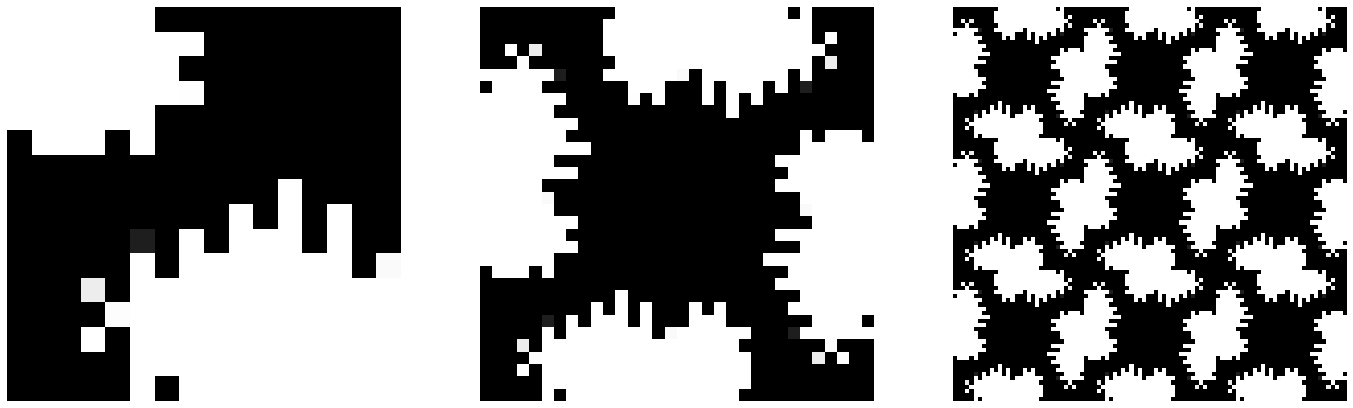

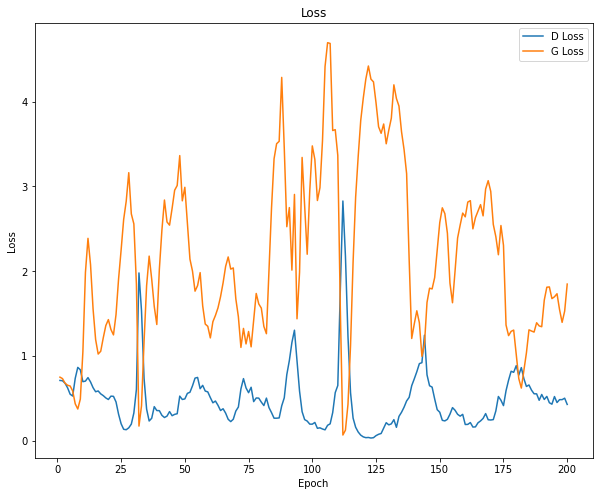

In [21]:
def train(G_model,D_model,GAN_model,input_G,porosity,tol_porosity,batch_size,num_epochs,tmp_models_dir,geom_epoch_dirs,seed_geom_gif,vstack=True,plot=False,verbose_loss=False,verbose_acc=False):
    for file in os.listdir(tmp_models_dir+'/G/'):
        os.remove(tmp_models_dir+'/G/'+file)

    for file in os.listdir(tmp_models_dir+'/D/'):
        os.remove(tmp_models_dir+'/D/'+file)

    for geom_file in os.listdir(geom_epoch_dirs):
        os.remove(geom_epoch_dirs+geom_file)

    batch_per_epoch = int(X_good.shape[0] /batch_size)
    half_batch = int(batch_size/2)
    
    G_losses = []
    D_losses = []

    fig,ax = plt.subplots(1,3);
    fig.set_size_inches((24,8))
    for i in range(num_epochs):
        G_losses_epoch = []
        D_losses_epoch = []
        for j in range(batch_per_epoch):
            if vstack:
                X_real,y_real = generate_real_samples(X_good,half_batch)
                X_fake,y_fake = generate_fake_samples(G_model,input_G,half_batch)            

                X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))
                
                if not verbose_loss:
                    D_loss = D_model.train_on_batch(x=[X,X,X], y=[y,porosity*np.ones(X.shape),0*np.ones(X.shape)])
                    D_loss = D_loss[0]
                else:
                    D_loss = D_model.train_on_batch(x=[X,X,X], y=[y,porosity*np.ones(X.shape),0*np.ones(X.shape)],return_dict=True)
                    # print(D_loss)
                    D_loss = D_loss['loss']
            else:
                X_real,y_real = generate_real_samples(X_good,half_batch)
                X_fake,y_fake = generate_fake_samples(G_model,input_G,half_batch)            
                X, y = np.vstack((X_real, X_fake)), np.vstack((y_real, y_fake))

                if not verbose_loss:
                    D_loss_real = D_model.train_on_batch(x=[X_real,X_real,X_real], y=[y_real,porosity*np.ones(X_real.shape),0*np.ones(X_real.shape)])
                    D_loss_real = D_loss_real[0]
                    D_loss_fake = D_model.train_on_batch(x=[X_fake,X_fake,X_fake], y=[y_fake,porosity*np.ones(X_fake.shape),0*np.ones(X_fake.shape)])
                    D_loss_fake = D_loss_fake[0]
                else:
                    D_loss_real = D_model.train_on_batch(x=[X_real,X_real,X_real], y=[y_real,porosity*np.ones(X_real.shape),0*np.ones(X_real.shape)],return_dict=True)
                    D_loss_real = D_loss_real['loss']
                    D_loss_fake = D_model.train_on_batch(x=[X_fake,X_fake,X_fake], y=[y_fake,porosity*np.ones(X_fake.shape),0*np.ones(X_fake.shape)],return_dict=True)
                    D_loss_fake = D_loss_fake['loss']
                
                D_loss = (D_loss_real+D_loss_fake)/2
            D_losses_epoch.append(D_loss)

            X_GAN = generate_input_G(input_G, batch_size)
            y_GAN = np.ones((batch_size, 1))

            if not verbose_loss:
                G_loss= GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X.shape),0*np.ones(X.shape)])
                G_loss = G_loss[0]
            else:
                G_loss= GAN_model.train_on_batch(x=X_GAN, y=[y_GAN,porosity*np.ones(X.shape),0*np.ones(X.shape)],return_dict=True)
                # print(G_loss)
                G_loss = G_loss['loss']

            if verbose_loss: 
                print('>%d, %d/%d, D_loss=%.3f, G_loss=%.3f' % (i+1, j+1, batch_per_epoch,  D_loss, G_loss))
            G_losses_epoch.append(G_loss)
        

        G_losses.append(np.array(G_losses_epoch).mean())
        D_losses.append(np.array(D_losses_epoch).mean())
        
        # export model
        if (i+1) % 10 == 0:
            acc_real,acc_fake = summarize_performance(i+1,porosity,G_model,D_model,X_good,input_G)

            X_test = generate_input_G(input_G,1000)
            geoms,_,_ = G_model.predict(X_test)
            geoms = np.array(geoms)
            por_match,_ = porosity_match(geoms, porosity, tol_porosity)
            G_model.save(tmp_models_dir+f'/G/epoch_{i+1}_por_{np.round(por_match,2)}_real_{np.round(acc_real,2)}_fake_{np.round(acc_fake,2)}.h5')
            D_model.save(tmp_models_dir+f'/D/epoch_{i+1}.h5')
            
            if verbose_acc:
                print('>Epoch: %i Porosity match: %.0f%% real: %.0f%% fake: %.0f%%' % (i+1, por_match*100, acc_real*100, acc_fake*100))

        # save geometry
        if (i+1) % 5 == 0:
            geom_gif_filename = geom_epoch_dirs + 'epoch_%03d.png'%(i+1)
            elem_gif,_,_ = G_model.predict(seed_geom_gif)
            size = elem_gif.shape[1]
            elem_gif = elem_gif.reshape((size,size))
            ax[0].imshow(elem_gif,cmap='Greys');
            ax[0].axis('off')

            unit_gif = create_unit(elem_gif,size,'p4') 
            ax[1].imshow(unit_gif,cmap='Greys');
            ax[1].axis('off')

            arrange_gif = create_arrange(unit_gif,3,3)
            ax[2].imshow(arrange_gif,cmap='Greys');
            ax[2].axis('off')
            plt.savefig(geom_gif_filename, bbox_inches='tight')

    G_losses = np.array(G_losses)
    D_losses = np.array(D_losses)
    if plot:
        plt.figure(figsize=((10,8)))
        plt.plot(list(range(1,num_epochs+1)),D_losses,label='D Loss')
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.plot(list(range(1,num_epochs+1)),G_losses,label='G Loss')
        plt.legend()
        plt.show()

batch_size = 64
num_epochs = 200
lr = 1e-4

alpha_por = 1e-1
alpha_val = 1e-1

porosity = 0.55
tol_porosity = 0.02

G = setup_G(input_G,output_G,size)
D = setup_D(input_D,lr,alpha_por,alpha_val)
GAN = setup_GAN(G,D,alpha_por,alpha_val,lr,size)

vstack=True
plot=True
verbose_loss=True
verbose_acc=True

seed_geom_gif = np.random.randn(input_G).reshape(1, input_G)

train(G,D,GAN,input_G,porosity,tol_porosity,batch_size,num_epochs,tmp_models_dir,geom_epoch_dirs,seed_geom_gif,vstack=vstack,plot=plot,verbose_loss=verbose_loss,verbose_acc=verbose_acc)

# Evaluate `Generator`

## Compile gif

In [13]:
with imageio.get_writer(gif_filename, mode='I') as writer:
    geom_filenames = os.listdir(geom_epoch_dirs)
    for geom_filename in geom_filenames:
        image = imageio.imread(geom_epoch_dirs+geom_filename)
        foo = cv2.putText(
                    image,
                    str((geom_filenames.index(geom_filename)+1)*5),
                    (5, 25),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (255, 0, 0),
                    2)
        for i in range(5):
            # image = imageio.imread(geom_epoch_dirs+geom_filename)
            writer.append_data(image)

## Visualize geometries

313/313 [==============================] - 1s 3ms/step


ValueError: Unexpected result of `predict_function` (Empty batch_outputs). Please use `Model.compile(..., run_eagerly=True)`, or `tf.config.run_functions_eagerly(True)` for more information of where went wrong, or file a issue/bug to `tf.keras`.

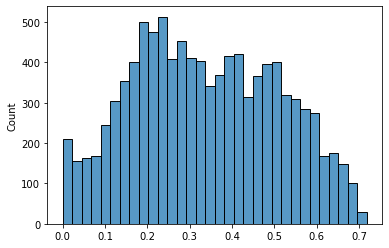

In [26]:
def check_unit(unit, desired_porosity, tol):
  labels = measure.label(unit,connectivity=1)
  main_label = 0
  main_label_count = 0
  passed = True

  element = unit[int(unit.shape[0]/2):,:int(unit.shape[0]/2)]

  for label in range(1,len(np.unique(labels))):
      label_count = np.where(labels==label)[0].shape[0]
      if label_count > main_label_count:
        main_label = label
        main_label_count = label_count

  void_count = 0

  for label in range(1,len(np.unique(labels))):
    if label not in [0,main_label]:
      void_count += np.where(labels==label)[0].shape[0]
      unit[np.where(labels==label)] = 0.

  porosity = get_porosity(unit)

  if porosity > desired_porosity - tol and porosity < desired_porosity + tol:
    for label in range(1,len(np.unique(labels))):
      if label not in [0,main_label]:
        unit[np.where(labels==label)] = 0.

    if unit[0,:].sum() > 0 and unit[:,0].sum() > 0:
      # check if there is connectivity right-left
      connections_rl = 0
      for i in range(unit.shape[0]):
        if (unit[i,0] == 1 and unit[i,-1] == 1):
          connections_rl += 1

      # check if there is connectivity top-bottom
      connections_tb = 0
      for j in range(unit.shape[1]):
        if (unit[0,j] == 1 and unit[-1,j] == 1):
          connections_tb += 1

      if connections_rl == 0 or connections_tb == 0:
        passed = False
      
    else:
      passed = False
      
  else:
    passed = False

  if passed:
    passed = False
    for i in range(element.shape[0]):
      if [element[i,0],element[element.shape[0]-1,element.shape[1]-i-1]]==[1,1]:
        passed = True

  return passed, element

def check_singularity(element, simmetry):
  passeds = [True for i in range(4)]

  # check singularities inside element
  for i in range(element.shape[0]-1):
    for j in range(element.shape[1]-1):
      # print(element[i:i+2,j:j+2])
      diag1 = list(element[i:i+2,j:j+2].diagonal())
      diag2 = list(np.fliplr(element[i:i+2,j:j+2]).diagonal())
      if (diag1 == [1,1] and diag2 == [0,0]) or (diag1 == [0,0] and diag2 == [1,1]):
        passeds[0] = False    

  # check singularities in element boundary and singularities in unit boundary
  if simmetry[1:] == '4':
    for j in range(element.shape[1]-1):
      arr = np.array([[element[element.shape[0]-j-1,element.shape[1]-1],element[element.shape[0]-j-2,element.shape[1]-1]],[element[0,j],element[0,j+1]]])
      diag1 = list(arr.diagonal())
      diag2 = list(np.fliplr(arr).diagonal())
      if (diag1 == [1,1] and diag2 == [0,0]) or (diag1 == [0,0] and diag2 == [1,1]):
        passeds[1] = False
      
      arr = np.array([[element[element.shape[0]-1,j],element[element.shape[0]-1,j+1]],[element[j,0],element[j+1,0]]])
      diag1 = list(arr.diagonal())
      diag2 = list(np.fliplr(arr).diagonal())
      if (diag1 == [1,1] and diag2 == [0,0]) or (diag1 == [0,0] and diag2 == [1,1]):
        passeds[2] = False
      if [element[0,0],element[element.shape[0]-1,element.shape[1]-1]] == [1, 0] or [element[0,0],element[element.shape[0]-1,element.shape[1]-1]] == [0, 1]:
        passeds[3] = False

  return passeds

epoch = 160
desired_porosity=0.55
tol = 0.02
simmetry = 'p4'
top = 20
save = True

# select model
G_files = os.listdir(tmp_models_dir+'/G/')
D_files = os.listdir(tmp_models_dir+'/D/')
for i in range(len(G_files)):
    G_file = G_files[i]
    D_file = D_files[i]
    if int(G_file.split('_')[1]) == epoch:
        G = load_model(tmp_models_dir+'/G/'+G_file)
        D = load_model(tmp_models_dir+'/D/'+D_file, custom_objects={'custom_loss':validity_loss()})
        break

# generate test data
test_size = 10000
X_test = generate_input_G(input_G,test_size)

geometries,_,_ = G.predict(X_test)
sns.histplot(1-np.sum(geometries.round().reshape((test_size,int(size*size))),axis=-1)/int(size*size),bins=32);

_, geometries = porosity_match(geometries, desired_porosity, tol)
size = geometries.shape[1]
elements = []

for i in range(len(geometries)):
  geom = geometries[i].reshape((size,size)).round()
  unit = create_unit(geom,size,simmetry)
  passed_connectivity,element = check_unit(unit, desired_porosity, tol)
  passed_singularity = check_singularity(element, simmetry)
  if passed_connectivity and all(passed_singularity):
  # if passed_connectivity:
    elements.append(element)

geometries = np.array(elements)

# Get scores
scores = D.predict([geometries,geometries,geometries])[0].ravel()
top_idxs = np.argsort(-scores)[:top]

if save: 
  if not os.path.exists(arrays_dir+G_file[:-3]):
    os.mkdir(arrays_dir+G_file[:-3])
    idx = 1
  else:
    try:
      idx = len(os.listdir(arrays_dir+G_file[:-3]))+1
    except: 
      idx = 1

  G.save(arrays_dir+G_file[:-3]+'/'+G_file)

for top_idx in top_idxs:
  elem = geometries[top_idx]
  unit = create_unit(elem.reshape((size,size)),size,simmetry)
  arrange = create_arrange(unit,3,3)
  
  print("Score: %.2f Porosity: %.2f"%(scores[top_idx],get_porosity(elem)))
  
  fig,ax = plt.subplots(1,3);
  fig.set_size_inches((15,5))
  
  ax[0].imshow(elem,cmap='Greys');
  ax[0].axis('off')
  
  ax[1].imshow(unit,cmap="Greys")
  ax[1].axis('off')

  ax[2].imshow(arrange,cmap="Greys")
  ax[2].axis('off')
  plt.show()

  if save:
    filename = arrays_dir + G_file[:-3] + "/%05d_porosity_%.4f.txt" % (idx, 1.0-elem.ravel().sum()/(size*size))
    np.savetxt(filename, elem.ravel(), delimiter='/n', fmt='%s')
    idx += 1